# Timing Experiments with matplotlib and IPython display
A few different computing environments are tested:
- ZBook-14 (2020) + py37-venv
- Colab
- macbook pro (2020)

General concerns with these timings:
- cashing HAS an impact on these multiple run style testing, so timings are indications on the optimal performance , not necessarily of first time execution time 

In [1]:
%matplotlib inline
import numpy as np
import time
import io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from IPython.display import display, clear_output, Audio, HTML, set_matplotlib_close, Image

#### 0. The non timed baseline

In [2]:
x = np.arange(0,1000)
y = x*x

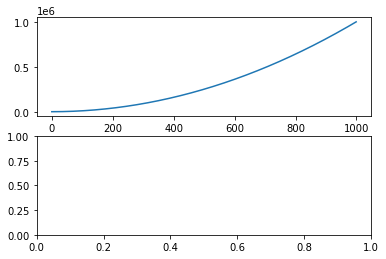

In [3]:
plt.close('all')
fig,ax = plt.subplots(2,1)
ax[0].plot(x,y);
plt.close()
fig

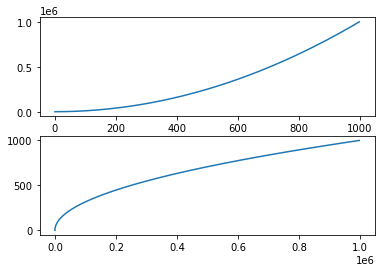

In [4]:
ax[1].plot(y,x)
fig

#### 1. Creating the (x,y) dataset
This has negligible load
- ZBook-14: 3.3 micro-sec

In [5]:
%%timeit -n 100
# simple assignment of arrays
x = np.arange(0,1000)
y = x*x

3.42 µs ± 1.46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 2. Inline Plotting
A simple axis plot is rendered.  Almost all time is consumed in the creation of the figure
The number of axis plots has a small effect on total load
- zbook: 28 msec

26.4 ms ± 455 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


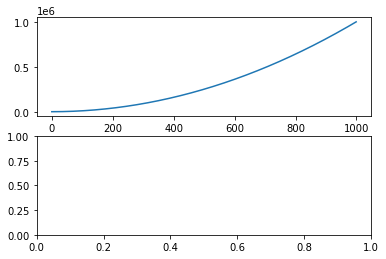

In [8]:
%%timeit -n 1 -r 3
plt.close('all')
fig,ax = plt.subplots(2,1)
ax[0].plot(x,y)

#### 3. Adding an axis to an existing figure and show it
- (a) via 'fig' as last command in cell: 
    + < 1msec, but not sure about this one, as no figure is shown in the timed loop, without the timing it does
- (b) via 'display()'
    + the display() function takes about 100msec on ZBook-14

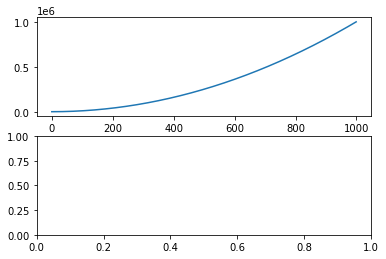

In [19]:
plt.close('all')
fig,ax = plt.subplots(2,1)
ax[0].plot(x,y);

In [18]:
%%timeit -n 1 -r 3
ax[1].plot(y,x)
fig

702 µs ± 132 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


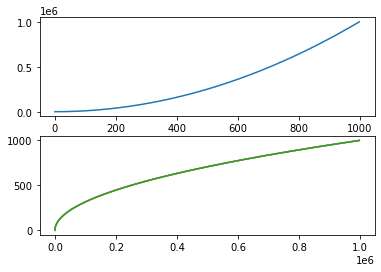

98.5 ms ± 3.04 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [21]:
%%timeit -n 1 -r 3
ax[1].plot(y,x)
clear_output(wait=True)
display(fig)

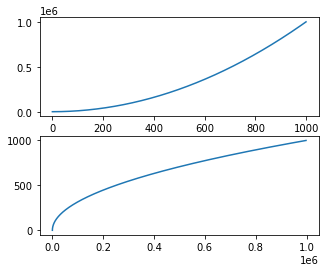

146 ms ± 3.97 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [32]:
%%timeit -r 3 -n 1
plt.close('all')
fig1,ax = plt.subplots(2,1,figsize=(5,4),dpi=72)
ax[0].plot(x,y)
ax[1].plot(y,x)
plt.close()
clear_output(wait=True)
display(fig1)

#### 4. Dissecting display() into fig -> png and png -> screen
- it is the fig -> png rendering that is taking up al the time
- the rendering on the screen is a minimal cost
- amazingly saving the .png to file with savefig() , loading the figure and displaying it with display() is faster than display() directly. ( writing/reading to file or IObuffer makes no big difference ) 
    + Not clear why simple display() is less efficient 
    + Does it create multiple renderings (not just .png) or what else is going on ??!! 

In [66]:
%%timeit -n 1 -r 3
plt.close('all')
fig,ax = plt.subplots(2,1,figsize=(5,4),dpi=72)
ax[0].plot(x,y)
ax[1].plot(y,x)
fig.savefig('dummy.png', format='png', dpi=fig.dpi)
plt.close()

80.6 ms ± 2.39 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


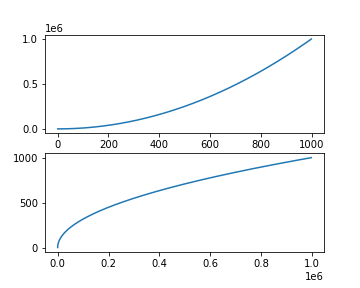

1.82 ms ± 114 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [68]:
%%timeit -n 3 -r 3
im=Image('dummy.png')
clear_output(wait=True)
display(im)

In [ ]:
#### 5. The FASTEST solution for updating a plot
- save it explicitly to a .png IO buffer
- render the IO buffer via display()

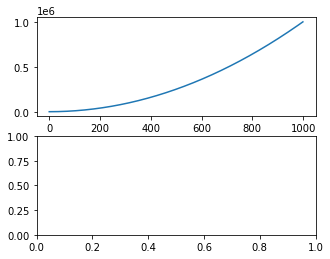

In [83]:
plt.close('all')
fig,ax = plt.subplots(2,1,figsize=(5,4),dpi=72)
ax[0].plot(x,y);

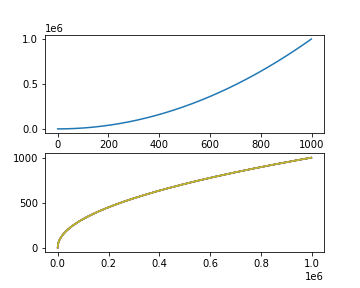

31.9 ms ± 2.56 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [84]:
%%timeit -n 3 -r 3
#ax[1].cla()
ax[1].plot(y,x)
buf = io.BytesIO()
fig.savefig(buf, format='png', dpi=fig.dpi)
#plt.close()
#
buf.seek(0)
im=Image(buf.read(),format='png')
clear_output(wait=True)
display(im)